 # Power Load Prediction for West Zone - Ensemble Model (24h)

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import pandas as pd
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [5]:
power_data_west = pd.read_csv("westdata_augmented.csv")

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_10419/1727164072.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  power_data_west = pd.read_csv("westdata_augmented.csv")


In [6]:
power_data_west['end'] = pd.to_datetime(power_data_west['end'], infer_datetime_format=True)
indexedDataset = power_data_west.set_index(['end'])

In [7]:
power_data_west['end'].min()

Timestamp('2019-01-29 00:15:00')

In [8]:
power_data_west['end'].max()

Timestamp('2022-01-25 16:00:00')

In [9]:
power_data_west.head()

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,sfm,index_y,dt,dt_iso,humidity,humidity_temp,pt_date
0,0,0,west,2019-01-29 00:00:00,2019-01-29 00:15:00,211.2,NaN,54.0,NaN,844.8,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
1,1,1,west,2019-01-29 00:15:00,2019-01-29 00:30:00,210.4,NaN,54.0,NaN,841.6,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
2,2,2,west,2019-01-29 00:30:00,2019-01-29 00:45:00,208.0,NaN,54.0,NaN,832.0,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
3,3,3,west,2019-01-29 00:45:00,2019-01-29 01:00:00,212.0,NaN,54.0,NaN,848.0,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
4,4,4,west,2019-01-29 01:00:00,2019-01-29 01:15:00,203.2,NaN,55.0,NaN,812.8,2019-01-29 01,681,1548752400,2019-01-29 09,21,63.41,2019-01-29 01


In [10]:
power_data_west['month'] = power_data_west['end'].dt.strftime('%b')

In [11]:
from calendar import month_abbr

lower_ma = [m.lower() for m in month_abbr]

# one-liner with Pandas
power_data_west['month_int'] = power_data_west['month'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')

In [14]:
power_data_west['day_of_week'] = power_data_west['end'].dt.day_name()

In [15]:
power_data_west['day_of_week_int'] = power_data_west['end'].dt.day_of_week

In [18]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

date_range = pd.date_range(start='2019-01-01', end='2022-01-27')

cal = calendar()
holidays = cal.holidays(start=date_range.min(), end=date_range.max())

power_data_west['holiday'] = power_data_west['end'].dt.date.astype('datetime64').isin(holidays)

In [19]:
power_data_west["holiday_int"] = power_data_west["holiday"].astype(int)

In [20]:
power_data_west_mod = power_data_west[['end','demand', 'temp', 'humidity', 'month_int', 'day_of_week_int', 'holiday_int']].copy() 

In [21]:
power_data_west_mod.head()

,end,demand,temp,humidity,month_int,day_of_week_int,holiday_int
0,2019-01-29 00:15:00,844.8,54.0,21,1,1,0
1,2019-01-29 00:30:00,841.6,54.0,21,1,1,0
2,2019-01-29 00:45:00,832.0,54.0,21,1,1,0
3,2019-01-29 01:00:00,848.0,54.0,21,1,1,0
4,2019-01-29 01:15:00,812.8,55.0,21,1,1,0


In [22]:
power_data_west_mod.describe()

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
count,104596.000000,104588.00000,104608.000000,104608.00000,104608.000000,104608.000000
mean,1238.634456,67.39232,52.635401,6.54298,2.998748,0.028449
std,302.399419,16.59371,22.815913,3.43464,2.002753,0.166253
min,0.000000,29.00000,3.000000,1.00000,0.000000,0.000000
25%,1008.000000,54.00000,34.000000,4.00000,1.000000,0.000000
50%,1232.000000,66.00000,49.000000,7.00000,3.000000,0.000000
75%,1472.000000,79.00000,70.000000,10.00000,5.000000,0.000000
max,2124.800000,114.00000,100.000000,12.00000,6.000000,1.000000


In [24]:
power_data_west_24 = power_data_west_mod.resample('D', on='end').agg({'demand':'sum', 'temp':'max', 'humidity':'max', 'month_int':'max', 'day_of_week_int':'max', 'holiday_int':'max'})

In [25]:
power_data_west_24.describe()

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
count,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000,1093.000000
mean,118532.671171,79.911253,70.422690,6.537054,2.998170,0.028362
std,28166.774387,16.415071,19.585791,3.443121,2.000915,0.166082
min,1155.200000,44.000000,12.000000,1.000000,0.000000,0.000000
25%,96940.800000,66.000000,55.000000,4.000000,1.000000,0.000000
50%,117507.200000,79.000000,70.000000,7.000000,3.000000,0.000000
75%,141232.000000,95.000000,90.000000,10.000000,5.000000,0.000000
max,190041.600000,114.000000,100.000000,12.000000,6.000000,1.000000


In [26]:
power_data_west_24['end_val'] = power_data_west_24.index.values
power_data_west_24

,demand,temp,humidity,month_int,day_of_week_int,holiday_int,end_val
end,,,,,,,
2019-01-29,87331.2,65.0,88,1,1,0,2019-01-29
2019-01-30,94944.0,71.0,89,1,2,0,2019-01-30
2019-01-31,94940.8,60.0,92,1,3,0,2019-01-31
2019-02-01,92905.6,63.0,79,2,4,0,2019-02-01
2019-02-02,87206.4,66.0,93,2,5,0,2019-02-02
...,...,...,...,...,...,...,...
2022-01-21,114214.4,60.0,92,1,4,0,2022-01-21
2022-01-22,88096.0,66.0,91,1,5,0,2022-01-22
2022-01-23,83523.2,68.0,61,1,6,0,2022-01-23


In [103]:
power_data_west_24_train = power_data_west_24[(power_data_west_24['end_val'] > '2019-02-06') & (power_data_west_24['end_val'] < '2021-03-06')]
power_data_west_24_train

,demand,temp,humidity,month_int,day_of_week_int,holiday_int,end_val
end,,,,,,,
2019-02-07,81196.8,56.0,93,2,3,0,2019-02-07
2019-02-08,80297.6,59.0,83,2,4,0,2019-02-08
2019-02-09,68700.8,57.0,90,2,5,0,2019-02-09
2019-02-10,64195.2,51.0,93,2,6,0,2019-02-10
2019-02-11,76297.6,53.0,95,2,0,0,2019-02-11
...,...,...,...,...,...,...,...
2021-03-01,121180.8,77.0,28,3,0,0,2021-03-01
2021-03-02,125212.8,78.0,25,3,1,0,2021-03-02
2021-03-03,121600.0,67.0,69,3,2,0,2021-03-03


In [104]:
power_data_west_24_test = power_data_west_24[(power_data_west_24['end_val'] > '2021-03-05') & (power_data_west_24['end_val'] < '2022-01-26')]
power_data_west_24_test

,demand,temp,humidity,month_int,day_of_week_int,holiday_int,end_val
end,,,,,,,
2021-03-06,128123.2,66.0,92,3,5,0,2021-03-06
2021-03-07,120928.0,62.0,89,3,6,0,2021-03-07
2021-03-08,122360.0,66.0,90,3,0,0,2021-03-08
2021-03-09,120076.8,62.0,88,3,1,0,2021-03-09
2021-03-10,115435.2,57.0,96,3,2,0,2021-03-10
...,...,...,...,...,...,...,...
2022-01-21,114214.4,60.0,92,1,4,0,2022-01-21
2022-01-22,88096.0,66.0,91,1,5,0,2022-01-22
2022-01-23,83523.2,68.0,61,1,6,0,2022-01-23


## Ensemble Model - Analysis

In [29]:
linear_model_test_results = pd.read_csv("24h_Linear_Model_Test_Results.csv")

In [30]:
linear_model_test_results

,end,Actual,Prediction,residual
0,2021-03-06,128123.2,118829.394623,9293.805377
1,2021-03-07,120928.0,115876.731106,5051.268894
2,2021-03-08,122360.0,125615.246647,-3255.246647
3,2021-03-09,120076.8,125112.460335,-5035.660335
4,2021-03-10,115435.2,122502.696759,-7067.496759
...,...,...,...,...
321,2022-01-21,114214.4,117646.453618,-3432.053618
322,2022-01-22,88096.0,111022.802466,-22926.802466
323,2022-01-23,83523.2,91836.878327,-8313.678327
324,2022-01-24,117772.8,103069.667937,14703.132063


In [31]:
linear_model_test_results['model'] = 'Linear Model'
linear_model_test_results['end'] = linear_model_test_results.index.values
linear_model_test_results

,end,Actual,Prediction,residual,model
0,0,128123.2,118829.394623,9293.805377,Linear Model
1,1,120928.0,115876.731106,5051.268894,Linear Model
2,2,122360.0,125615.246647,-3255.246647,Linear Model
3,3,120076.8,125112.460335,-5035.660335,Linear Model
4,4,115435.2,122502.696759,-7067.496759,Linear Model
...,...,...,...,...,...
321,321,114214.4,117646.453618,-3432.053618,Linear Model
322,322,88096.0,111022.802466,-22926.802466,Linear Model
323,323,83523.2,91836.878327,-8313.678327,Linear Model
324,324,117772.8,103069.667937,14703.132063,Linear Model


In [32]:
randomforest_model_test_results = pd.read_csv("24h_RandomForest_Model_Test_Results.csv")

In [33]:
randomforest_model_test_results

,end,Actual,Prediction,residual
0,2021-03-06,128123.2,117604.00000,10519.20000
1,2021-03-07,120928.0,120580.17920,347.82080
2,2021-03-08,122360.0,122061.21280,298.78720
3,2021-03-09,120076.8,123963.03360,-3886.23360
4,2021-03-10,115435.2,120719.24160,-5284.04160
...,...,...,...,...
321,2022-01-21,114214.4,120644.95680,-6430.55680
322,2022-01-22,88096.0,107101.63840,-19005.63840
323,2022-01-23,83523.2,95046.88604,-11523.68604
324,2022-01-24,117772.8,104167.47832,13605.32168


In [34]:
randomforest_model_test_results['residual'] = randomforest_model_test_results['Actual'] - randomforest_model_test_results['Prediction']
randomforest_model_test_results['model'] = 'Random Forest'
randomforest_model_test_results['end'] = randomforest_model_test_results.index.values
randomforest_model_test_results

,end,Actual,Prediction,residual,model
0,0,128123.2,117604.00000,10519.20000,Random Forest
1,1,120928.0,120580.17920,347.82080,Random Forest
2,2,122360.0,122061.21280,298.78720,Random Forest
3,3,120076.8,123963.03360,-3886.23360,Random Forest
4,4,115435.2,120719.24160,-5284.04160,Random Forest
...,...,...,...,...,...
321,321,114214.4,120644.95680,-6430.55680,Random Forest
322,322,88096.0,107101.63840,-19005.63840,Random Forest
323,323,83523.2,95046.88604,-11523.68604,Random Forest
324,324,117772.8,104167.47832,13605.32168,Random Forest


In [35]:
SVR_model_test_results = pd.read_csv("24h_SVR_Model_Test_Results.csv")

In [36]:
SVR_model_test_results

,Unnamed: 0,Actual,Prediction
0,0,128123.2,113972.554704
1,1,120928.0,110518.683124
2,2,122360.0,119147.609036
3,3,120076.8,122996.025409
4,4,115435.2,117717.218254
...,...,...,...
321,321,114214.4,113358.962035
322,322,88096.0,109566.882695
323,323,83523.2,97112.080194
324,324,117772.8,105309.871882


In [37]:
SVR_model_test_results['residual'] = SVR_model_test_results['Actual'] - SVR_model_test_results['Prediction']
SVR_model_test_results['model'] = 'SVR'
SVR_model_test_results

,Unnamed: 0,Actual,Prediction,residual,model
0,0,128123.2,113972.554704,14150.645296,SVR
1,1,120928.0,110518.683124,10409.316876,SVR
2,2,122360.0,119147.609036,3212.390964,SVR
3,3,120076.8,122996.025409,-2919.225409,SVR
4,4,115435.2,117717.218254,-2282.018254,SVR
...,...,...,...,...,...
321,321,114214.4,113358.962035,855.437965,SVR
322,322,88096.0,109566.882695,-21470.882695,SVR
323,323,83523.2,97112.080194,-13588.880194,SVR
324,324,117772.8,105309.871882,12462.928118,SVR


In [38]:
XGBoost_model_test_results = pd.read_csv("24h_XGBoost_Model_Test_Results.csv")

In [39]:
XGBoost_model_test_results

,end,Actual,Prediction,residual
0,2021-03-06,128123.2,116378.970,11744.231250
1,2021-03-07,120928.0,114447.110,6480.890625
2,2021-03-08,122360.0,117660.070,4699.929688
3,2021-03-09,120076.8,123152.670,-3075.871875
4,2021-03-10,115435.2,123853.336,-8418.135938
...,...,...,...,...
321,2022-01-21,114214.4,119280.690,-5066.287500
322,2022-01-22,88096.0,109939.900,-21843.898438
323,2022-01-23,83523.2,94223.660,-10700.456250
324,2022-01-24,117772.8,103362.484,14410.315625


In [41]:
XGBoost_model_test_results['residual'] = XGBoost_model_test_results['Actual'] - XGBoost_model_test_results['Prediction']
XGBoost_model_test_results['model'] = 'XG Boost'
XGBoost_model_test_results['end'] = XGBoost_model_test_results.index.values
XGBoost_model_test_results

,end,Actual,Prediction,residual,model
0,0,128123.2,116378.970,11744.230,XG Boost
1,1,120928.0,114447.110,6480.890,XG Boost
2,2,122360.0,117660.070,4699.930,XG Boost
3,3,120076.8,123152.670,-3075.870,XG Boost
4,4,115435.2,123853.336,-8418.136,XG Boost
...,...,...,...,...,...
321,321,114214.4,119280.690,-5066.290,XG Boost
322,322,88096.0,109939.900,-21843.900,XG Boost
323,323,83523.2,94223.660,-10700.460,XG Boost
324,324,117772.8,103362.484,14410.316,XG Boost


In [42]:
KNNR_model_test_results = pd.read_csv("24h_KNNR_Model_Test_Results.csv")

In [43]:
KNNR_model_test_results

,end,Actual,Prediction,residual
0,2021-03-06,128123.2,117794.56,10328.64
1,2021-03-07,120928.0,120825.60,102.40
2,2021-03-08,122360.0,125118.72,-2758.72
3,2021-03-09,120076.8,120247.68,-170.88
4,2021-03-10,115435.2,115153.28,281.92
...,...,...,...,...
321,2022-01-21,114214.4,123265.60,-9051.20
322,2022-01-22,88096.0,119246.40,-31150.40
323,2022-01-23,83523.2,108838.72,-25315.52
324,2022-01-24,117772.8,101084.80,16688.00


In [44]:
KNNR_model_test_results['residual'] = KNNR_model_test_results['Actual'] - KNNR_model_test_results['Prediction']
KNNR_model_test_results['model'] = 'KNN Regression'
KNNR_model_test_results['end'] = KNNR_model_test_results.index.values
KNNR_model_test_results

,end,Actual,Prediction,residual,model
0,0,128123.2,117794.56,10328.64,KNN Regression
1,1,120928.0,120825.60,102.40,KNN Regression
2,2,122360.0,125118.72,-2758.72,KNN Regression
3,3,120076.8,120247.68,-170.88,KNN Regression
4,4,115435.2,115153.28,281.92,KNN Regression
...,...,...,...,...,...
321,321,114214.4,123265.60,-9051.20,KNN Regression
322,322,88096.0,119246.40,-31150.40,KNN Regression
323,323,83523.2,108838.72,-25315.52,KNN Regression
324,324,117772.8,101084.80,16688.00,KNN Regression


In [45]:
test_results =pd.concat([linear_model_test_results, randomforest_model_test_results, SVR_model_test_results, XGBoost_model_test_results, KNNR_model_test_results], axis=0)

In [46]:
test_results['MAPE'] = (abs(test_results['Actual'] - test_results['Prediction'])/test_results['Prediction'] ) *100
test_results['MAE'] = abs(test_results['Actual'] - test_results['Prediction'])

In [47]:
test_results

,end,Actual,Prediction,residual,model,Unnamed: 0,MAPE,MAE
0,0.0,128123.2,118829.394623,9293.805377,Linear Model,NaN,7.821133,9293.805377
1,1.0,120928.0,115876.731106,5051.268894,Linear Model,NaN,4.359174,5051.268894
2,2.0,122360.0,125615.246647,-3255.246647,Linear Model,NaN,2.591442,3255.246647
3,3.0,120076.8,125112.460335,-5035.660335,Linear Model,NaN,4.024907,5035.660335
4,4.0,115435.2,122502.696759,-7067.496759,Linear Model,NaN,5.769258,7067.496759
...,...,...,...,...,...,...,...,...
321,321.0,114214.4,123265.600000,-9051.200000,KNN Regression,NaN,7.342843,9051.200000
322,322.0,88096.0,119246.400000,-31150.400000,KNN Regression,NaN,26.122717,31150.400000
323,323.0,83523.2,108838.720000,-25315.520000,KNN Regression,NaN,23.259663,25315.520000
324,324.0,117772.8,101084.800000,16688.000000,KNN Regression,NaN,16.508911,16688.000000


/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='MAPE'>

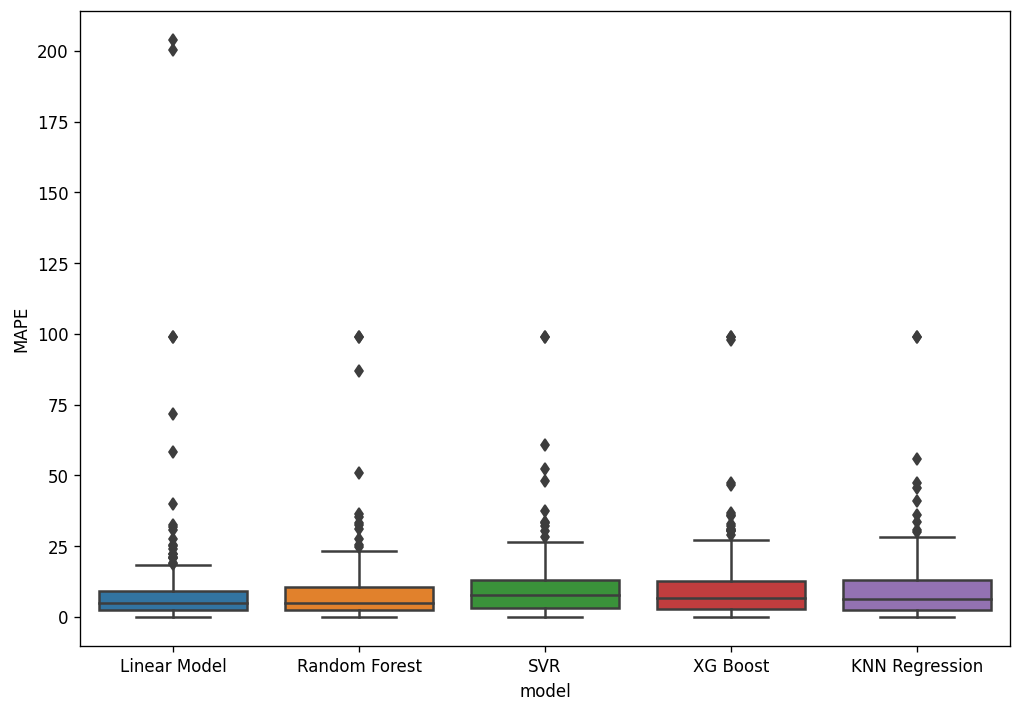

In [48]:
from seaborn import boxplot

boxplot(test_results['model'], test_results['MAPE'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='residual'>

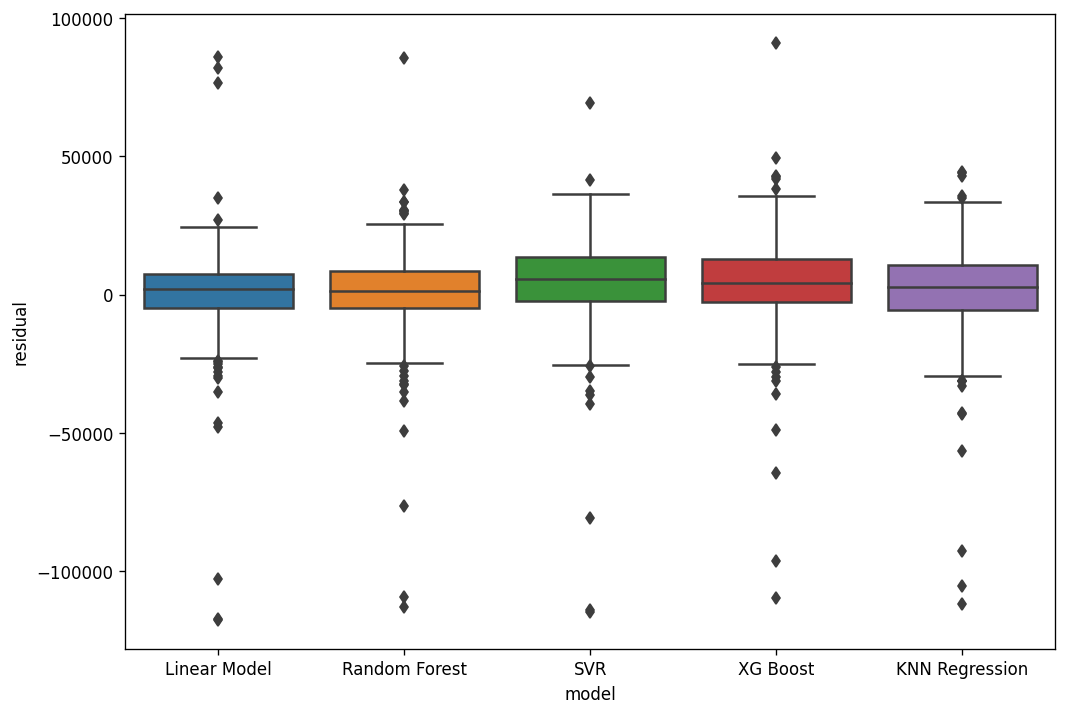

In [49]:
boxplot(test_results['model'], test_results['residual'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='MAE'>

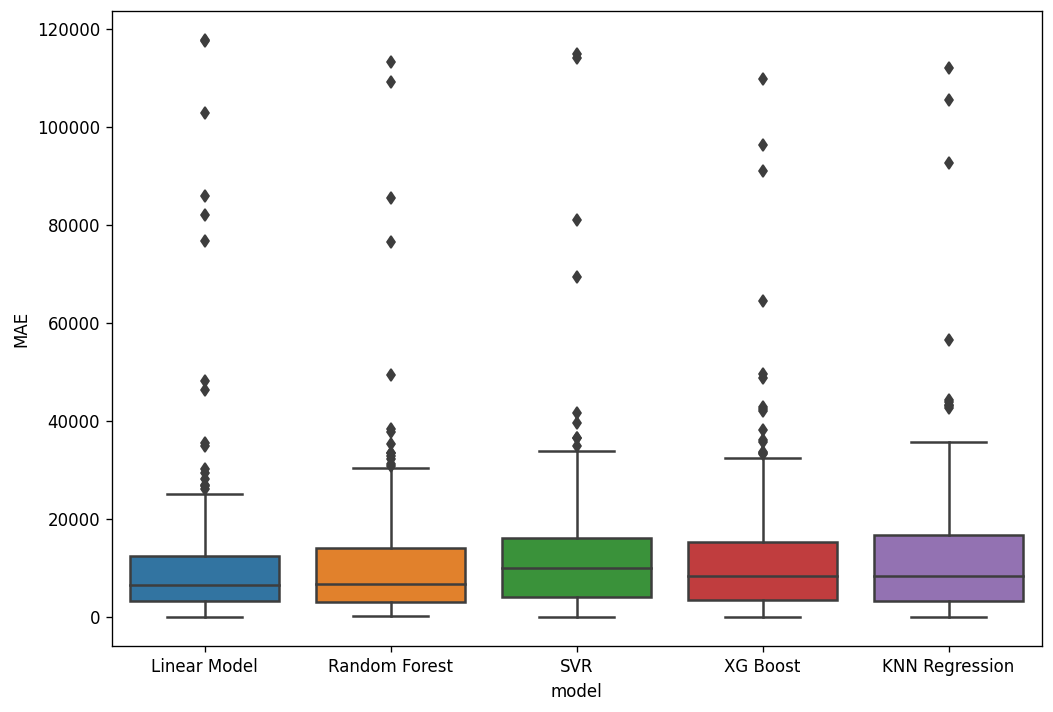

In [50]:
boxplot(test_results['model'], test_results['MAE'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='Prediction'>

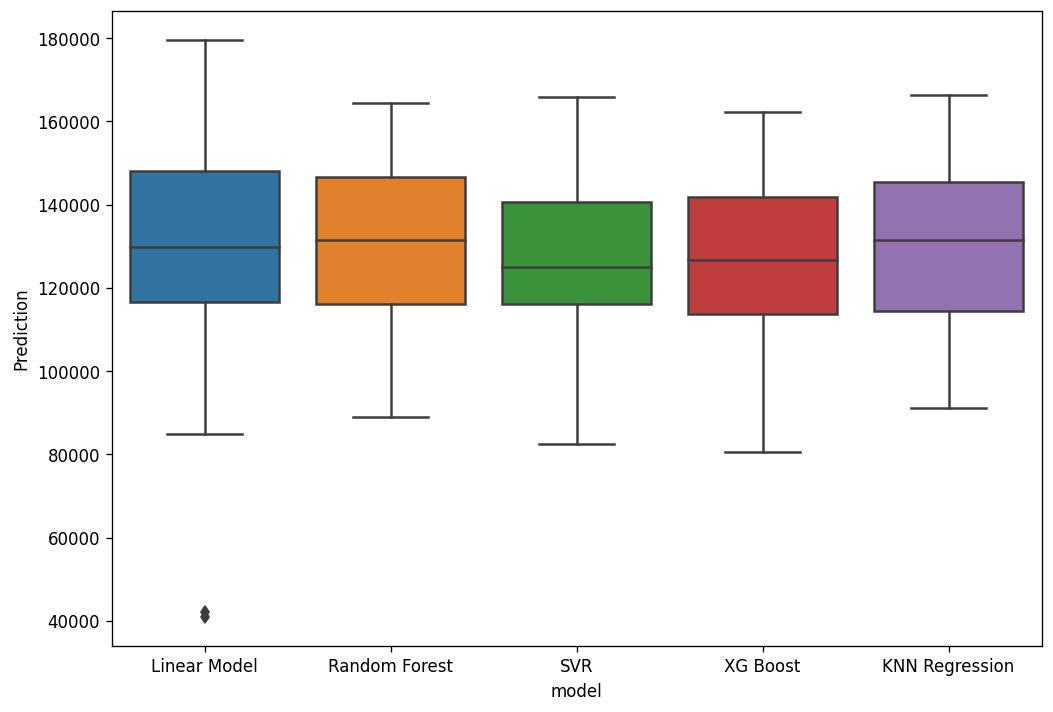

In [58]:
boxplot(test_results['model'], test_results['Prediction'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='Actual'>

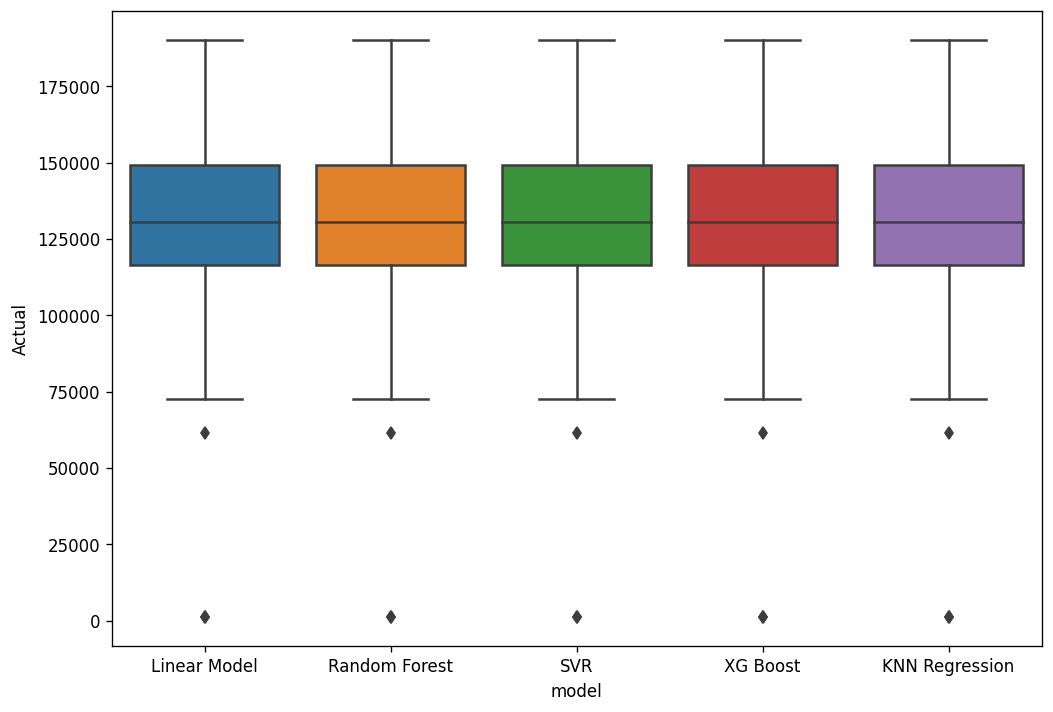

In [52]:
boxplot(test_results['model'], test_results['Actual'])

## Ensemble Model

In [53]:
linear_model_train_results = pd.read_csv("24h_Linear_Model_Train_Results.csv")
linear_model_train_results

,end,Actual,Prediction,residual
0,2019-02-07,81196.8,79862.203931,1334.596069
1,2019-02-08,80297.6,80063.459882,234.140118
2,2019-02-09,68700.8,78785.359792,-10084.559792
3,2019-02-10,64195.2,68112.950037,-3917.750037
4,2019-02-11,76297.6,74199.434990,2098.165010
...,...,...,...,...
753,2021-03-01,121180.8,115195.623286,5985.176714
754,2021-03-02,125212.8,124340.309873,872.490127
755,2021-03-03,121600.0,123617.129421,-2017.129421
756,2021-03-04,115507.2,121286.625570,-5779.425570


In [62]:
randomforest_model_train_results = pd.read_csv("24h_RandomForest_Model_Train_Results.csv")
randomforest_model_train_results

,end,Actual,Prediction,residual
0,2019-02-07,81196.8,81276.8896,-80.0896
1,2019-02-08,80297.6,81263.7312,-966.1312
2,2019-02-09,68700.8,72169.0304,-3468.2304
3,2019-02-10,64195.2,64991.8528,-796.6528
4,2019-02-11,76297.6,77072.0608,-774.4608
...,...,...,...,...
753,2021-03-01,121180.8,117967.0944,3213.7056
754,2021-03-02,125212.8,123229.7248,1983.0752
755,2021-03-03,121600.0,121427.4912,172.5088
756,2021-03-04,115507.2,117041.7344,-1534.5344


In [63]:
XGBoost_model_train_results = pd.read_csv("24h_XGBoost_Model_Train_Results.csv")
XGBoost_model_train_results

,end,Actual,Prediction,residual
0,2019-02-07,81196.8,81196.760,0.042188
1,2019-02-08,80297.6,80297.625,-0.025000
2,2019-02-09,68700.8,68700.850,-0.051562
3,2019-02-10,64195.2,64195.180,0.020312
4,2019-02-11,76297.6,76297.630,-0.032812
...,...,...,...,...
753,2021-03-01,121180.8,121180.750,0.050000
754,2021-03-02,125212.8,125212.770,0.026563
755,2021-03-03,121600.0,121600.010,-0.007812
756,2021-03-04,115507.2,115507.195,0.004687


In [64]:
KNNR_model_train_results = pd.read_csv("24h_KNNR_Model_Train_Results.csv")
KNNR_model_train_results

,end,Actual,Prediction,residual
0,2019-02-07,81196.8,82115.20,-918.40
1,2019-02-08,80297.6,84481.92,-4184.32
2,2019-02-09,68700.8,79909.12,-11208.32
3,2019-02-10,64195.2,65309.44,-1114.24
4,2019-02-11,76297.6,78907.84,-2610.24
...,...,...,...,...
753,2021-03-01,121180.8,110805.12,10375.68
754,2021-03-02,125212.8,116748.16,8464.64
755,2021-03-03,121600.0,117754.88,3845.12
756,2021-03-04,115507.2,117883.20,-2376.00


In [65]:
SVR_model_train_results = pd.read_csv("24h_SVR_Model_Train_Results.csv")
SVR_model_train_results['residual'] = SVR_model_train_results['Actual'] - SVR_model_train_results['Prediction']
SVR_model_train_results

,Unnamed: 0,Actual,Prediction,residual
0,0,81196.8,79256.736683,1940.063317
1,1,80297.6,83056.920940,-2759.320940
2,2,68700.8,77849.274259,-9148.474259
3,3,64195.2,66939.537305,-2744.337305
4,4,76297.6,78686.227193,-2388.627193
...,...,...,...,...
753,753,121180.8,116697.463958,4483.336042
754,754,125212.8,122776.996583,2435.803417
755,755,121600.0,118872.791368,2727.208632
756,756,115507.2,114449.147000,1058.053000


In [112]:
ensemble_train = pd.DataFrame({ 
                               'Linear_Actual':linear_model_train_results['Actual'], 
                               'Linear_Prediction':linear_model_train_results['Prediction'] ,
    
                               'RandomForest_Actual':randomforest_model_test_results['Actual'], 
                               'RandomForest_Prediction':randomforest_model_test_results['Prediction'] ,
    
                               'XGBoost_Actual':XGBoost_model_train_results['Actual'], 
                               'XGBoost_Prediction':XGBoost_model_train_results['Prediction'] ,
                                
                               'KNNR_Actual':KNNR_model_train_results['Actual'], 
                               'KNNR_Prediction':KNNR_model_train_results['Prediction'] ,
        
                               'SVR_Actual':SVR_model_train_results['Actual'], 
                               'SVR_Prediction':SVR_model_train_results['Prediction'] ,
                                
                               'demand':power_data_west_24_train['demand'].to_numpy(), 
                                'month_int':power_data_west_24_train['month_int'].to_numpy(), 
                               'day_of_week_int':power_data_west_24_train['day_of_week_int'].to_numpy(),  
                               'holiday_int':power_data_west_24_train['holiday_int'].to_numpy()

                             })

ensemble_train

,Linear_Actual,Linear_Prediction,RandomForest_Actual,RandomForest_Prediction,XGBoost_Actual,XGBoost_Prediction,KNNR_Actual,KNNR_Prediction,SVR_Actual,SVR_Prediction,demand,month_int,day_of_week_int,holiday_int
0,81196.8,79862.203931,81196.8,81276.8896,81196.8,81196.760,81196.8,82115.20,81196.8,79256.736683,81196.8,2,3,0
1,80297.6,80063.459882,80297.6,81263.7312,80297.6,80297.625,80297.6,84481.92,80297.6,83056.920940,80297.6,2,4,0
2,68700.8,78785.359792,68700.8,72169.0304,68700.8,68700.850,68700.8,79909.12,68700.8,77849.274259,68700.8,2,5,0
3,64195.2,68112.950037,64195.2,64991.8528,64195.2,64195.180,64195.2,65309.44,64195.2,66939.537305,64195.2,2,6,0
4,76297.6,74199.434990,76297.6,77072.0608,76297.6,76297.630,76297.6,78907.84,76297.6,78686.227193,76297.6,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,121180.8,115195.623286,121180.8,117967.0944,121180.8,121180.750,121180.8,110805.12,121180.8,116697.463958,121180.8,3,0,0
754,125212.8,124340.309873,125212.8,123229.7248,125212.8,125212.770,125212.8,116748.16,125212.8,122776.996583,125212.8,3,1,0
755,121600.0,123617.129421,121600.0,121427.4912,121600.0,121600.010,121600.0,117754.88,121600.0,118872.791368,121600.0,3,2,0
756,115507.2,121286.625570,115507.2,117041.7344,115507.2,115507.195,115507.2,117883.20,115507.2,114449.147000,115507.2,3,3,0


In [113]:
ensemble_train.shape

(758, 14)

In [115]:
ensemble_test = pd.DataFrame({ 
                               'Linear_Actual':linear_model_test_results['Actual'], 
                               'Linear_Prediction':linear_model_test_results['Prediction'] ,
    
                               'RandomForest_Actual':randomforest_model_test_results['Actual'], 
                               'RandomForest_Prediction':randomforest_model_test_results['Prediction'] ,
    
                               'XGBoost_Actual':XGBoost_model_test_results['Actual'], 
                               'XGBoost_Prediction':XGBoost_model_test_results['Prediction'] ,
                                
                               'KNNR_Actual':KNNR_model_test_results['Actual'], 
                               'KNNR_Prediction':KNNR_model_test_results['Prediction'] ,
        
                               'SVR_Actual':SVR_model_test_results['Actual'], 
                               'SVR_Prediction':SVR_model_test_results['Prediction'] ,
                                
                               'demand':power_data_west_24_test['demand'].to_numpy(), 
                                'month_int':power_data_west_24_test['month_int'].to_numpy(), 
                               'day_of_week_int':power_data_west_24_test['day_of_week_int'].to_numpy(),  
                               'holiday_int':power_data_west_24_test['holiday_int'].to_numpy()

                             })

ensemble_test

,Linear_Actual,Linear_Prediction,RandomForest_Actual,RandomForest_Prediction,XGBoost_Actual,XGBoost_Prediction,KNNR_Actual,KNNR_Prediction,SVR_Actual,SVR_Prediction,demand,month_int,day_of_week_int,holiday_int
0,128123.2,118829.394623,128123.2,117604.00000,128123.2,116378.970,128123.2,117794.56,128123.2,113972.554704,128123.2,3,5,0
1,120928.0,115876.731106,120928.0,120580.17920,120928.0,114447.110,120928.0,120825.60,120928.0,110518.683124,120928.0,3,6,0
2,122360.0,125615.246647,122360.0,122061.21280,122360.0,117660.070,122360.0,125118.72,122360.0,119147.609036,122360.0,3,0,0
3,120076.8,125112.460335,120076.8,123963.03360,120076.8,123152.670,120076.8,120247.68,120076.8,122996.025409,120076.8,3,1,0
4,115435.2,122502.696759,115435.2,120719.24160,115435.2,123853.336,115435.2,115153.28,115435.2,117717.218254,115435.2,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,114214.4,117646.453618,114214.4,120644.95680,114214.4,119280.690,114214.4,123265.60,114214.4,113358.962035,114214.4,1,4,0
322,88096.0,111022.802466,88096.0,107101.63840,88096.0,109939.900,88096.0,119246.40,88096.0,109566.882695,88096.0,1,5,0
323,83523.2,91836.878327,83523.2,95046.88604,83523.2,94223.660,83523.2,108838.72,83523.2,97112.080194,83523.2,1,6,0
324,117772.8,103069.667937,117772.8,104167.47832,117772.8,103362.484,117772.8,101084.80,117772.8,105309.871882,117772.8,1,0,0


In [120]:
X_train = ensemble_train.drop(['Linear_Actual', 'RandomForest_Actual', 'XGBoost_Actual', 'KNNR_Actual', 'SVR_Actual', 'demand'], axis=1)
X_train

,Linear_Prediction,RandomForest_Prediction,XGBoost_Prediction,KNNR_Prediction,SVR_Prediction,month_int,day_of_week_int,holiday_int
0,79862.203931,81276.8896,81196.760,82115.20,79256.736683,2,3,0
1,80063.459882,81263.7312,80297.625,84481.92,83056.920940,2,4,0
2,78785.359792,72169.0304,68700.850,79909.12,77849.274259,2,5,0
3,68112.950037,64991.8528,64195.180,65309.44,66939.537305,2,6,0
4,74199.434990,77072.0608,76297.630,78907.84,78686.227193,2,0,0
...,...,...,...,...,...,...,...,...
753,115195.623286,117967.0944,121180.750,110805.12,116697.463958,3,0,0
754,124340.309873,123229.7248,125212.770,116748.16,122776.996583,3,1,0
755,123617.129421,121427.4912,121600.010,117754.88,118872.791368,3,2,0
756,121286.625570,117041.7344,115507.195,117883.20,114449.147000,3,3,0


In [121]:
y_train = ensemble_train['demand']
y_train

0       81196.8
1       80297.6
2       68700.8
3       64195.2
4       76297.6
         ...   
753    121180.8
754    125212.8
755    121600.0
756    115507.2
757    120764.8
Name: demand, Length: 758, dtype: float64

In [122]:
X_test = ensemble_test.drop(['Linear_Actual', 'RandomForest_Actual', 'XGBoost_Actual', 'KNNR_Actual', 'SVR_Actual', 'demand'], axis=1)
X_test

,Linear_Prediction,RandomForest_Prediction,XGBoost_Prediction,KNNR_Prediction,SVR_Prediction,month_int,day_of_week_int,holiday_int
0,118829.394623,117604.00000,116378.970,117794.56,113972.554704,3,5,0
1,115876.731106,120580.17920,114447.110,120825.60,110518.683124,3,6,0
2,125615.246647,122061.21280,117660.070,125118.72,119147.609036,3,0,0
3,125112.460335,123963.03360,123152.670,120247.68,122996.025409,3,1,0
4,122502.696759,120719.24160,123853.336,115153.28,117717.218254,3,2,0
...,...,...,...,...,...,...,...,...
321,117646.453618,120644.95680,119280.690,123265.60,113358.962035,1,4,0
322,111022.802466,107101.63840,109939.900,119246.40,109566.882695,1,5,0
323,91836.878327,95046.88604,94223.660,108838.72,97112.080194,1,6,0
324,103069.667937,104167.47832,103362.484,101084.80,105309.871882,1,0,0


In [123]:
y_test = ensemble_test['demand']
y_test

0      128123.2
1      120928.0
2      122360.0
3      120076.8
4      115435.2
         ...   
321    114214.4
322     88096.0
323     83523.2
324    117772.8
325     80412.8
Name: demand, Length: 326, dtype: float64

In [126]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

print('Start Model Training')
#ensemble_lr = LinearRegression(fit_intercept=True)
ensemble_model = RandomForestRegressor(n_estimators=10000)
ensemble_model.fit(X_train, y_train)
print(' Model Training Completed')

Start Model Training
 Model Training Completed


In [128]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

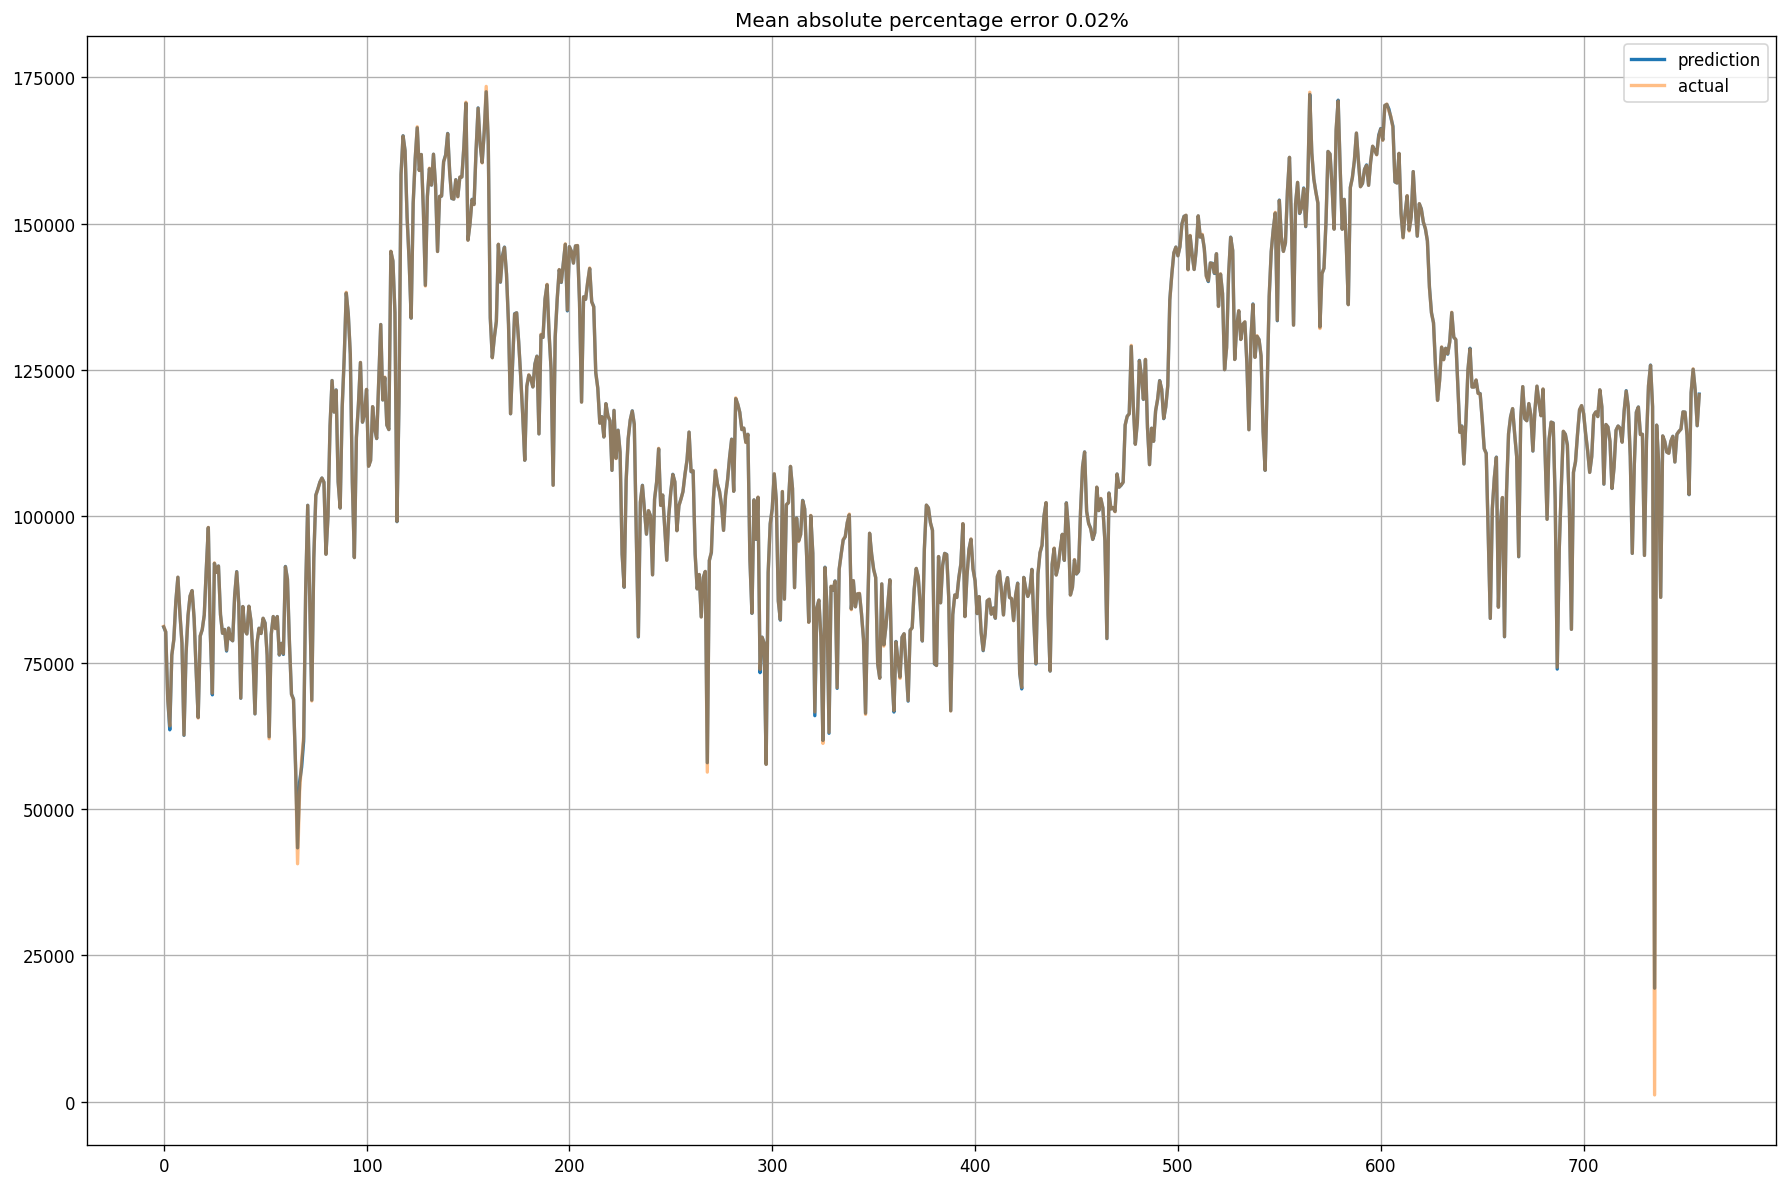

In [130]:
def plotModelTrainingResults(model, X_train=X_train, X_test=X_test):
  
    prediction = model.predict(X_train)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction, label="prediction", linewidth=2.0)
    plt.plot(y_train.values, label="actual", linewidth=2.0, alpha=0.5)

    mape_error_var = mean_absolute_percentage_error(y_train, prediction)
    mae_error_var = mean_absolute_error(y_train, prediction)
    mse_error_var = mean_squared_error(y_train, prediction, squared=True)
    rmse_error_var = mean_squared_error(y_train, prediction, squared=False)
    
    plt.title("Mean absolute percentage error {0:.2f}%".format(mape_error_var))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
    results = pd.DataFrame({'Actual':y_train, 
                            'Prediction':prediction  
                           })
    
    return results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var
    
train_results, train_mape_error_var, train_mae_error_var, train_mse_error_var, train_rmse_error_var = plotModelTrainingResults(ensemble_model)

In [131]:
print('MAPE: ' , train_mape_error_var)
print('MAE: ', train_mae_error_var)
print('MSE: ', train_mse_error_var)
print('RMSE: ', train_rmse_error_var)

MAPE:  0.02141806544984284
MAE:  74.48497130851085
MSE:  464401.87493441027
RMSE:  681.4703771510617


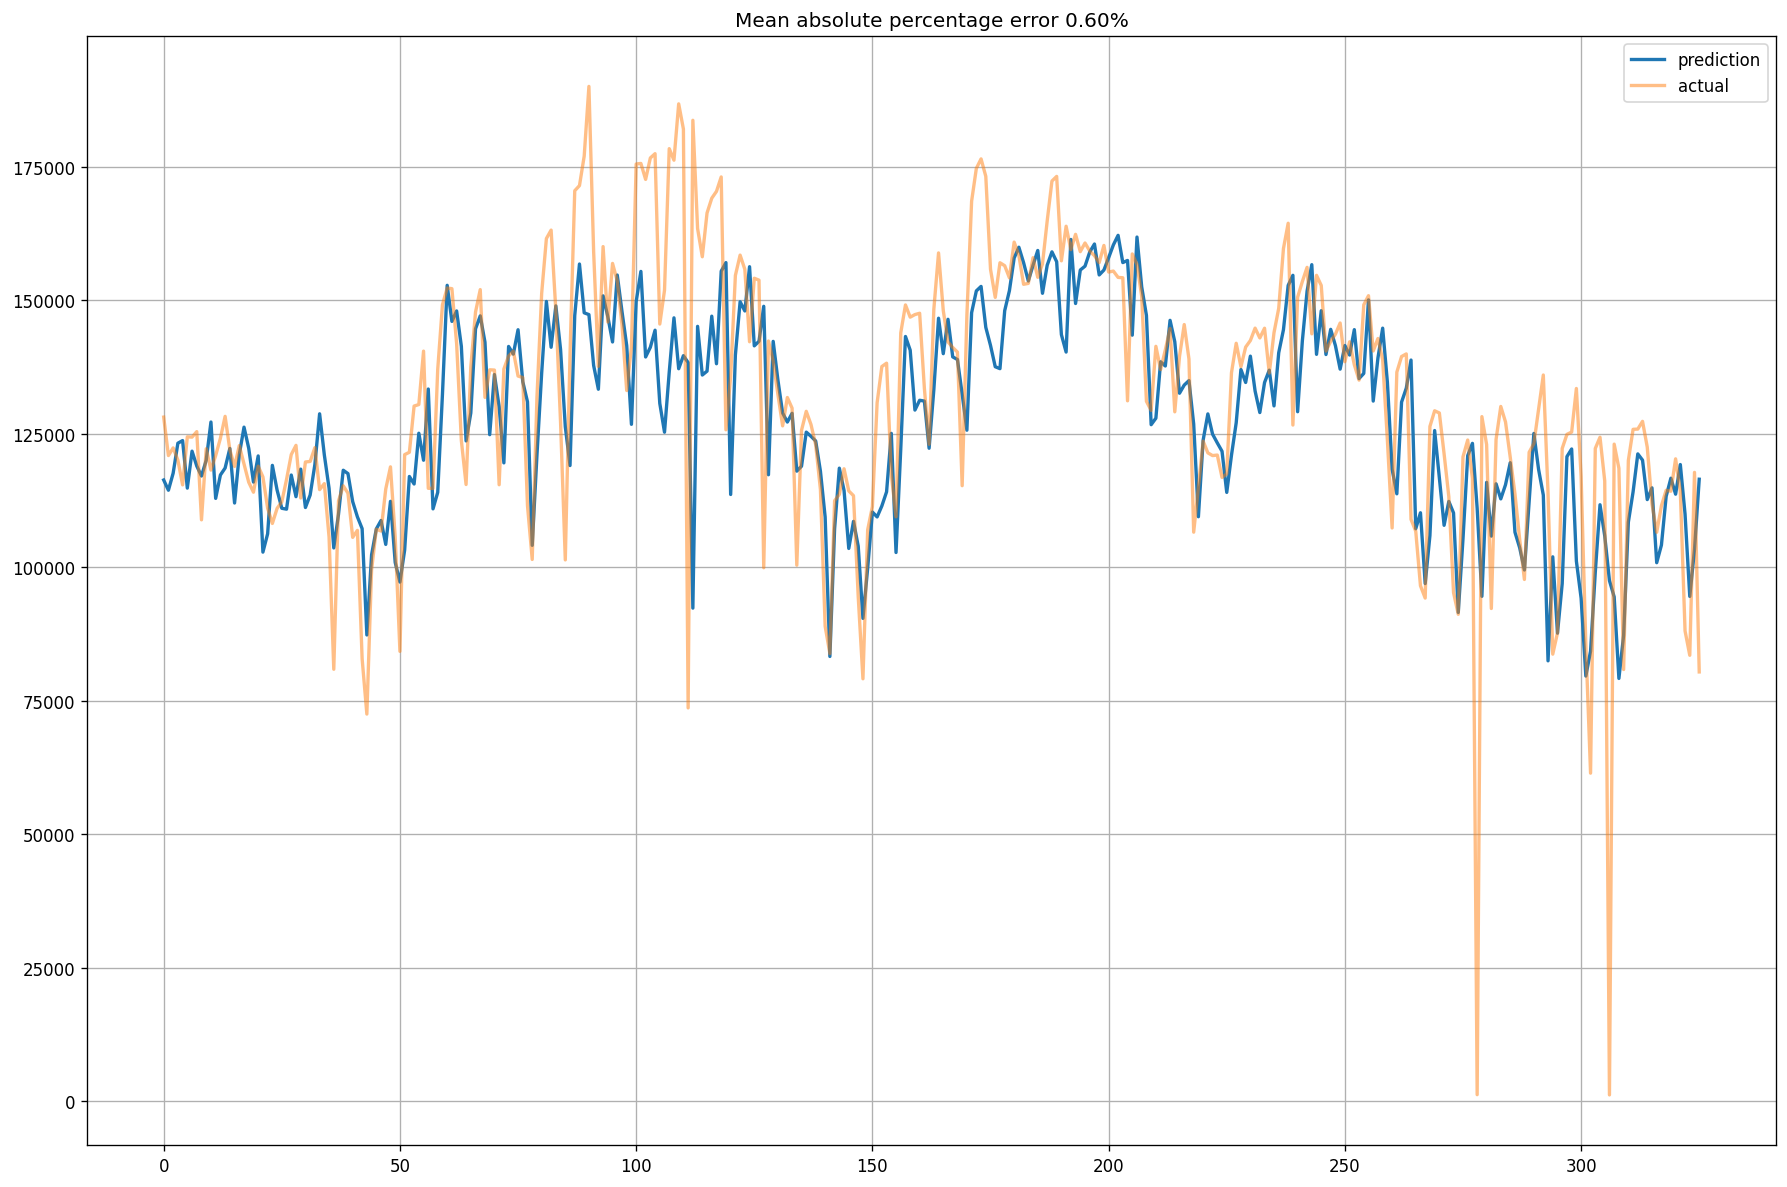

In [132]:
def plotModelPredictions(model, X_train=X_train, X_test=X_test):
  
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction, label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0, alpha=0.5)

    mape_error_var = mean_absolute_percentage_error(y_test, prediction)
    mae_error_var = mean_absolute_error(y_test, prediction)
    mse_error_var = mean_squared_error(y_test, prediction, squared=True)
    rmse_error_var = mean_squared_error(y_test, prediction, squared=False)
    
    plt.title("Mean absolute percentage error {0:.2f}%".format(mape_error_var))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
    results = pd.DataFrame({'Actual':y_test, 
                            'Prediction':prediction  
                           })
    
    return results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var
    
results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var = plotModelPredictions(ensemble_model)

In [133]:
results['residual'] = results['Actual'] - results['Prediction']
results['model'] = 'Ensemble Model'
results

,Actual,Prediction,residual,model
0,128123.2,116346.11728,11777.08272,Ensemble Model
1,120928.0,114433.40896,6494.59104,Ensemble Model
2,122360.0,117614.55008,4745.44992,Ensemble Model
3,120076.8,123236.66704,-3159.86704,Ensemble Model
4,115435.2,123733.61472,-8298.41472,Ensemble Model
...,...,...,...,...
321,114214.4,119243.65584,-5029.25584,Ensemble Model
322,88096.0,109970.20672,-21874.20672,Ensemble Model
323,83523.2,94548.57584,-11025.37584,Ensemble Model
324,117772.8,103308.65680,14464.14320,Ensemble Model


In [134]:
print('MAPE: ' , mape_error_var)
print('MAE: ', mae_error_var)
print('MSE: ', mse_error_var)
print('RMSE: ', rmse_error_var)

MAPE:  0.5976503485606062
MAE:  11929.309447579162
MSE:  312351613.80307084
RMSE:  17673.47203588109


In [135]:
test_results = pd.concat([test_results, results], axis=0) 

In [136]:
test_results['MAPE'] = (abs(test_results['Actual'] - test_results['Prediction'])/test_results['Prediction'] ) *100
test_results['MAE'] = abs(test_results['Actual'] - test_results['Prediction'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='MAE'>

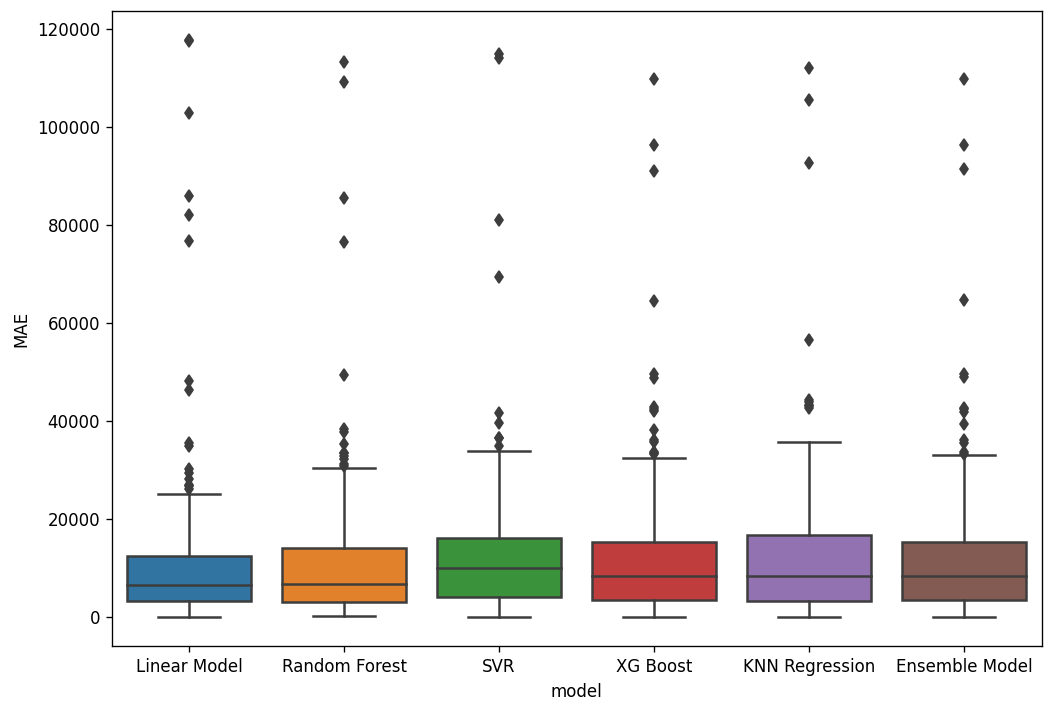

In [137]:
boxplot(test_results['model'], test_results['MAE'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='MAPE'>

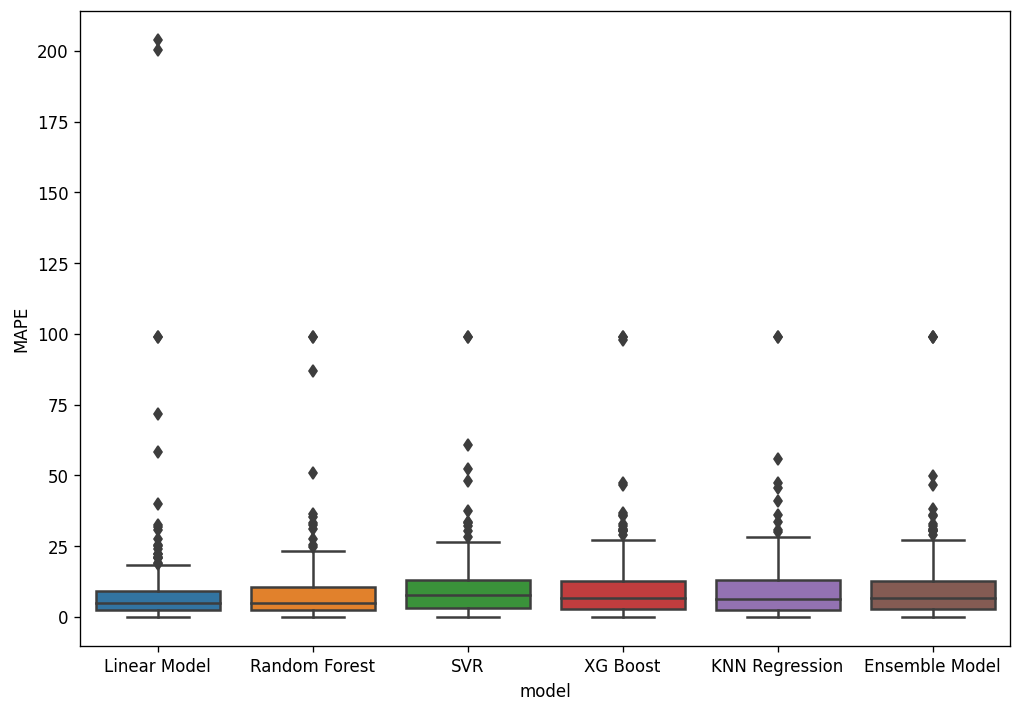

In [138]:
boxplot(test_results['model'], test_results['MAPE'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='Prediction'>

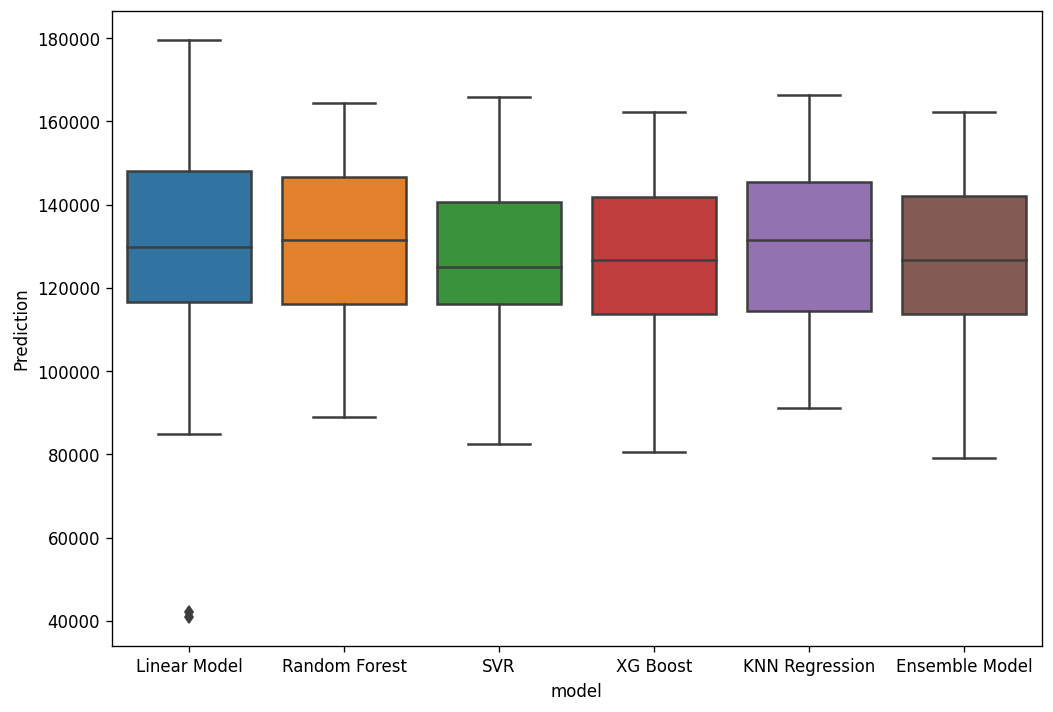

In [139]:
boxplot(test_results['model'], test_results['Prediction'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='Actual'>

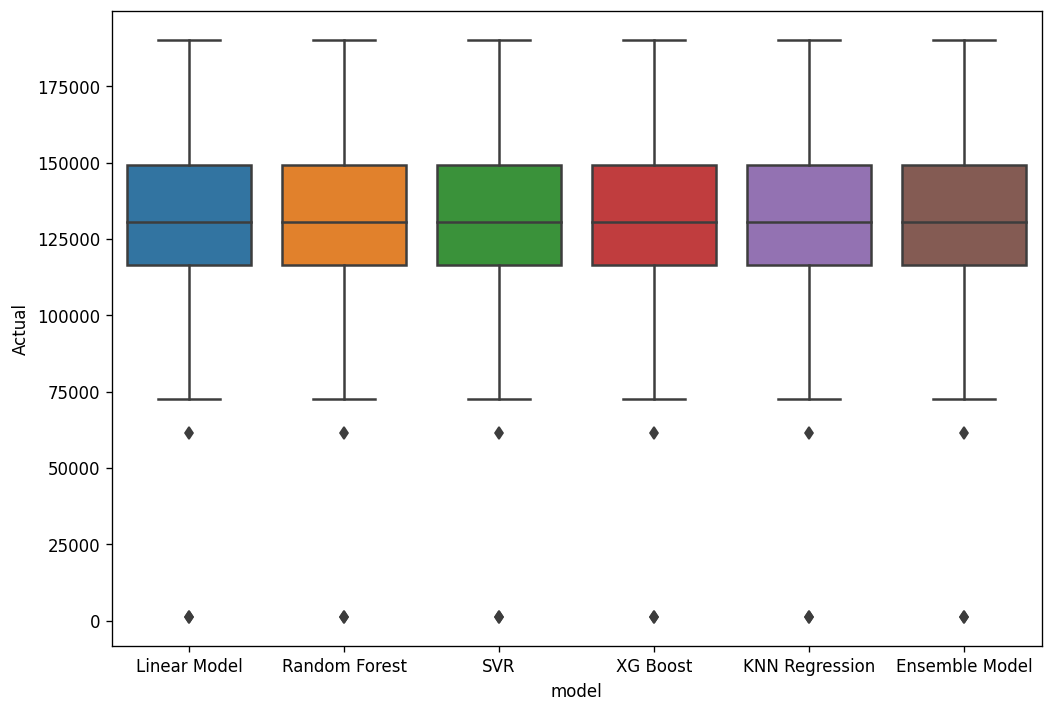

In [140]:
boxplot(test_results['model'], test_results['Actual'])

<AxesSubplot:xlabel='Feature'>

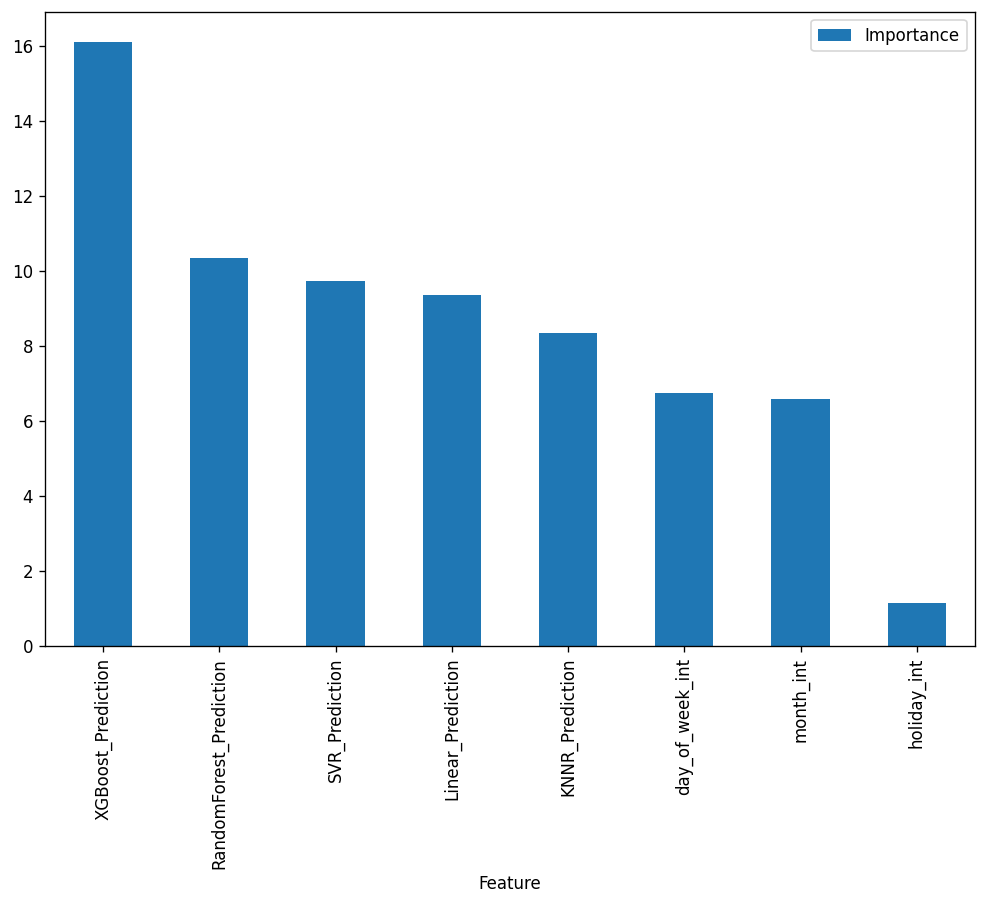

In [148]:
feature_importance = pd.concat([pd.DataFrame(ensemble_model.feature_names_in_, columns = ['Feature']), 
                                pd.DataFrame(np.log(ensemble_model.feature_importances_*10000000), columns = ['Importance'])], axis=1)
feature_importance["abs"] = feature_importance.Importance.apply(np.abs)
feature_importance = feature_importance.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
feature_importance.plot.bar(x='Feature', y='Importance', rot=90)

In [144]:
feature_importance

,Feature,Importance
2,XGBoost_Prediction,9.933933e-01
1,RandomForest_Prediction,3.153064e-03
4,SVR_Prediction,1.696761e-03
0,Linear_Prediction,1.174794e-03
3,KNNR_Prediction,4.250760e-04
6,day_of_week_int,8.437936e-05
5,month_int,7.226737e-05
7,holiday_int,3.137068e-07


In [149]:
model_index = ['Linear Model', 'XG Boost Model', 'Random Forest Model', 'Support Vector Regression Model', 'k Nearest Neighbour Regression Model', 'Ensemble Model']
model_results = pd.DataFrame({ 
                               'train_mape':[0.185, 3.8590329331013276e-07, 0.07284738602398275, 0.1734193064108206, 0.16161047420889982, 0.02141806544984284],
                               'test_mape':[0.6604, 0.59717, 0.6306, 0.6562902311187893, 0.6319143954250851, 0.5976503485606062]
                             }, index=model_index)
model_results

,train_mape,test_mape
Linear Model,1.850000e-01,0.660400
XG Boost Model,3.859033e-07,0.597170
Random Forest Model,7.284739e-02,0.630600
Support Vector Regression Model,1.734193e-01,0.656290
k Nearest Neighbour Regression Model,1.616105e-01,0.631914
Ensemble Model,2.141807e-02,0.597650


<AxesSubplot:>

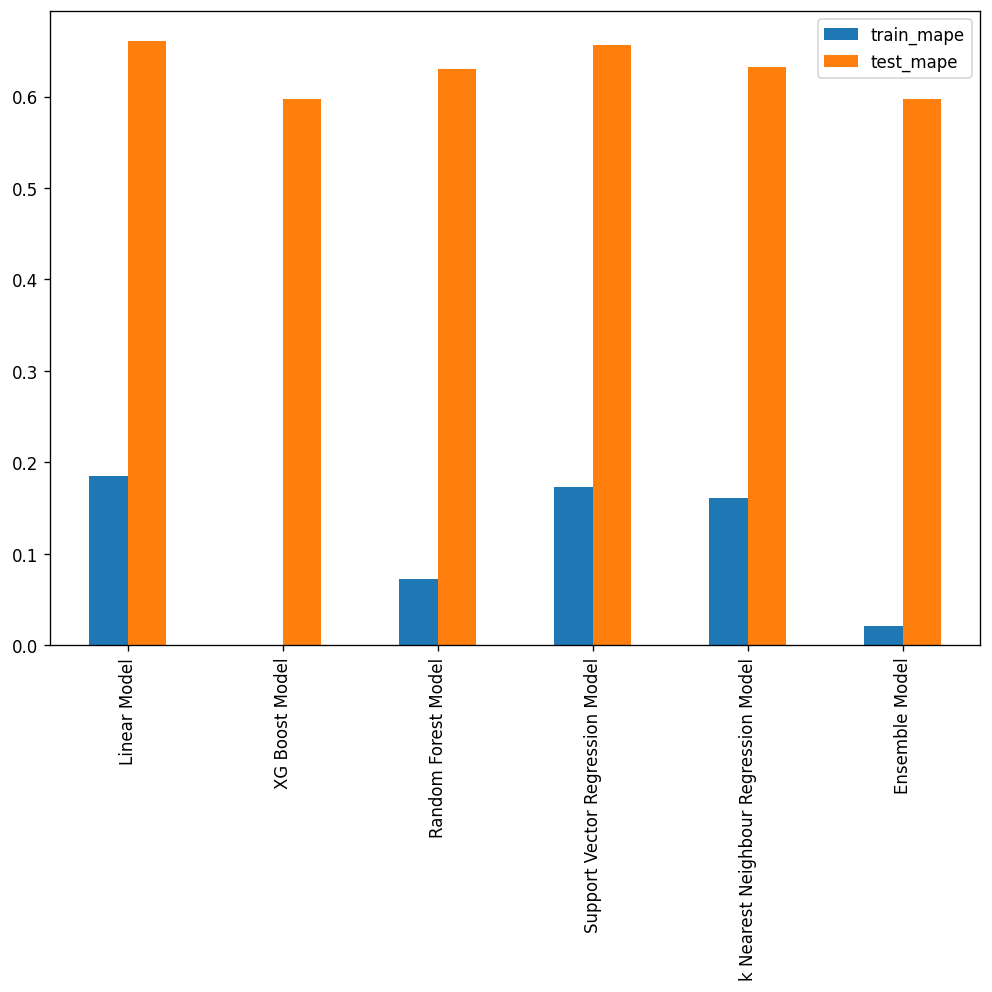

In [150]:
model_results.plot.bar()

In [145]:
import joblib
joblib.dump(ensemble_model, "./ensemble_model_24h.joblib")

['./ensemble_model_24h.joblib']